<a href="https://colab.research.google.com/github/mshilpaa/EVA4/blob/master/Session%206/l1_0.00005%20l2_0.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


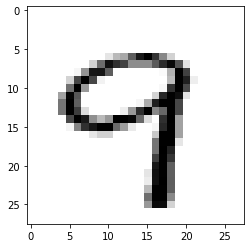

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

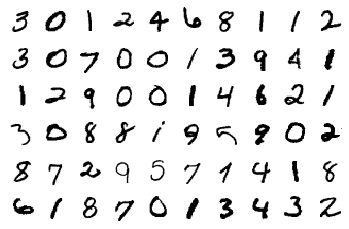

In [0]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False), # i/p= 28 o/p=26 r=3
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(p=0.05),

            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False), # i/p=26  o/p=24 r=5
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(p=0.05),
            
            nn.MaxPool2d(kernel_size=(2,2)), # i/p=24  o/p=12 r=6  

            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # i/p=12  o/p=10 r=10
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(p=0.05),
            

            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # i/p=10  o/p=8 r=14
            nn.ReLU(),
            nn.BatchNorm2d(num_features=12),
            nn.Dropout(p=0.05),

            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # i/p=8  o/p=6 r=18
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(p=0.05),

            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # i/p=6  o/p=4 r=22
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(p=0.05),

            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # i/p=4  o/p=2 r=26
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(p=0.05),

            nn.AdaptiveAvgPool2d(1),

            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),


        ) 

    def forward(self, x):

        x = self.convblock1(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             720
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 12, 10, 10]           1,080
             ReLU-11           [-1, 12, 10, 10]               0
      BatchNorm2d-12           [-1, 12, 10, 10]              24
          Dropout-13           [-1, 12, 10, 10]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
def L1_loss(model, data, factor):
  l1_crit = nn.L1Loss().to(device)
  reg_loss = 0
  for param in model.parameters():
    zero_vector = torch.rand_like(param) * 0
    reg_loss += l1_crit(param, zero_vector)
  return factor * reg_loss

In [0]:
def misclassified_images(misclassify):
  j=0
  fig = plt.figure(figsize=(15,15)) 
  for i in range(25): 
      ax = fig.add_subplot(5,5 , 1 + j) # 4 rows, 3 columns, 1+j is the index which gives position of each image in the plot
      plt.imshow(misclassify[i][0].cpu().numpy().squeeze(), cmap='gray_r') # display the image
      title = "Predicted: "+ str(misclassify[i][1][0].data.cpu().numpy())+" Target: "+ str(misclassify[i][2].data.cpu().numpy())
      ax.set_title(title) # give the class of the image as its title
      j+=1
  plt.subplots_adjust( hspace=0.5, wspace=0.35)      
  plt.show()

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
misclassify = []

def train(model, device, train_loader, optimizer, epoch, use_l1 = False,l1_factor = 0.0005):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    if use_l1 == True:
      loss += L1_loss(model,data,factor=l1_factor)

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # output is the probability for each class
            
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            for i in range(len(pred)):
              if pred[i] != target[i]:
                misclassify.append([data[i],pred[i],target[i]])
            
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    # print("o === ",pred,"-------target = ",target,"output",output.shape)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    # print(len(misclassify))
    # print(misclassify[0][0].size()) 
    test_acc.append(100. * correct / len(test_loader.dataset))

    # j=0
    # fig = plt.figure(figsize=(15,15)) 
    # for i in range(25): 
    #     ax = fig.add_subplot(7,4 , 1 + j) # 4 rows, 3 columns, 1+j is the index which gives position of each image in the plot
    #     plt.imshow(misclassify[i][0].cpu().numpy().squeeze(), cmap='gray_r') # display the image
    #     title = "predicted: "+ str(misclassify[i][1].data.cpu().numpy())+"target: "+ str(misclassify[i][2].data.cpu().numpy())
    #     ax.set_title(title) # give the class of the image as its title
    #     j+=1      
    # plt.show()

# Let's Train and test our model

In [0]:
from torch.optim.lr_scheduler import StepLR,MultiStepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
scheduler = MultiStepLR(optimizer, milestones=[6,8,12], gamma=0.1)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch,"lr = ",optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    misclassify = []
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0 lr =  0.01


Loss=0.1400844007730484 Batch_id=468 Accuracy=91.36: 100%|██████████| 469/469 [00:12<00:00, 39.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0516, Accuracy: 9856/10000 (98.56%)

EPOCH: 1 lr =  0.01


Loss=0.12096967548131943 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:12<00:00, 38.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0453, Accuracy: 9865/10000 (98.65%)

EPOCH: 2 lr =  0.01


Loss=0.037555430084466934 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:12<00:00, 36.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9894/10000 (98.94%)

EPOCH: 3 lr =  0.01


Loss=0.027012409642338753 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:12<00:00, 36.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9902/10000 (99.02%)

EPOCH: 4 lr =  0.01


Loss=0.037005096673965454 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:12<00:00, 46.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9918/10000 (99.18%)

EPOCH: 5 lr =  0.01


Loss=0.009809042327105999 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:11<00:00, 39.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9914/10000 (99.14%)

EPOCH: 6 lr =  0.001


Loss=0.014261703006923199 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:12<00:00, 47.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9932/10000 (99.32%)

EPOCH: 7 lr =  0.001


Loss=0.004565874580293894 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:12<00:00, 37.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9932/10000 (99.32%)

EPOCH: 8 lr =  0.0001


Loss=0.004968106746673584 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:12<00:00, 38.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9932/10000 (99.32%)

EPOCH: 9 lr =  0.0001


Loss=0.0033425886649638414 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 39.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9934/10000 (99.34%)

EPOCH: 10 lr =  0.0001


Loss=0.05858728662133217 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:11<00:00, 39.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9935/10000 (99.35%)

EPOCH: 11 lr =  0.0001


Loss=0.007693673018366098 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:12<00:00, 39.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9933/10000 (99.33%)

EPOCH: 12 lr =  1e-05


Loss=0.10356447845697403 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:11<00:00, 40.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9935/10000 (99.35%)

EPOCH: 13 lr =  1e-05


Loss=0.004335517529398203 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 39.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9932/10000 (99.32%)

EPOCH: 14 lr =  1e-05


Loss=0.002929608104750514 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:11<00:00, 40.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9937/10000 (99.37%)

EPOCH: 15 lr =  1e-05


Loss=0.006151142064481974 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:11<00:00, 39.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9935/10000 (99.35%)

EPOCH: 16 lr =  1e-05


Loss=0.04889899864792824 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:11<00:00, 43.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9933/10000 (99.33%)

EPOCH: 17 lr =  1e-05


Loss=0.011383523233234882 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 46.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9932/10000 (99.32%)

EPOCH: 18 lr =  1e-05


Loss=0.03349946811795235 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:11<00:00, 41.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9935/10000 (99.35%)

EPOCH: 19 lr =  1e-05


Loss=0.04776190593838692 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:12<00:00, 38.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9934/10000 (99.34%)

EPOCH: 20 lr =  1e-05


Loss=0.07474125176668167 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:12<00:00, 38.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9936/10000 (99.36%)

EPOCH: 21 lr =  1e-05


Loss=0.006857881788164377 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:11<00:00, 42.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9931/10000 (99.31%)

EPOCH: 22 lr =  1e-05


Loss=0.06071808934211731 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:11<00:00, 39.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9934/10000 (99.34%)

EPOCH: 23 lr =  1e-05


Loss=0.0331091545522213 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:11<00:00, 42.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9934/10000 (99.34%)

EPOCH: 24 lr =  1e-05


Loss=0.03651727735996246 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 40.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9932/10000 (99.32%)

EPOCH: 25 lr =  1e-05


Loss=0.029479628428816795 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:11<00:00, 41.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9936/10000 (99.36%)

EPOCH: 26 lr =  1e-05


Loss=0.042544905096292496 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:12<00:00, 39.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9935/10000 (99.35%)

EPOCH: 27 lr =  1e-05


Loss=0.04813101515173912 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 41.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9935/10000 (99.35%)

EPOCH: 28 lr =  1e-05


Loss=0.018705615773797035 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:11<00:00, 41.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9933/10000 (99.33%)

EPOCH: 29 lr =  1e-05


Loss=0.011428341269493103 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:11<00:00, 40.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9934/10000 (99.34%)

EPOCH: 30 lr =  1e-05


Loss=0.04099707677960396 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:10<00:00, 42.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9934/10000 (99.34%)

EPOCH: 31 lr =  1e-05


Loss=0.01624150574207306 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:11<00:00, 40.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9931/10000 (99.31%)

EPOCH: 32 lr =  1e-05


Loss=0.023246079683303833 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:11<00:00, 42.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9936/10000 (99.36%)

EPOCH: 33 lr =  1e-05


Loss=0.004562988877296448 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:11<00:00, 39.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9938/10000 (99.38%)

EPOCH: 34 lr =  1e-05


Loss=0.0021379936952143908 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:11<00:00, 40.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9935/10000 (99.35%)

EPOCH: 35 lr =  1e-05


Loss=0.008188907988369465 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:11<00:00, 41.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9931/10000 (99.31%)

EPOCH: 36 lr =  1e-05


Loss=0.05403810739517212 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:10<00:00, 43.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9934/10000 (99.34%)

EPOCH: 37 lr =  1e-05


Loss=0.01598511077463627 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:11<00:00, 40.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9932/10000 (99.32%)

EPOCH: 38 lr =  1e-05


Loss=0.022385692223906517 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:12<00:00, 38.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9935/10000 (99.35%)

EPOCH: 39 lr =  1e-05


Loss=0.007559786085039377 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:10<00:00, 43.35it/s]



Test set: Average loss: 0.0208, Accuracy: 9933/10000 (99.33%)



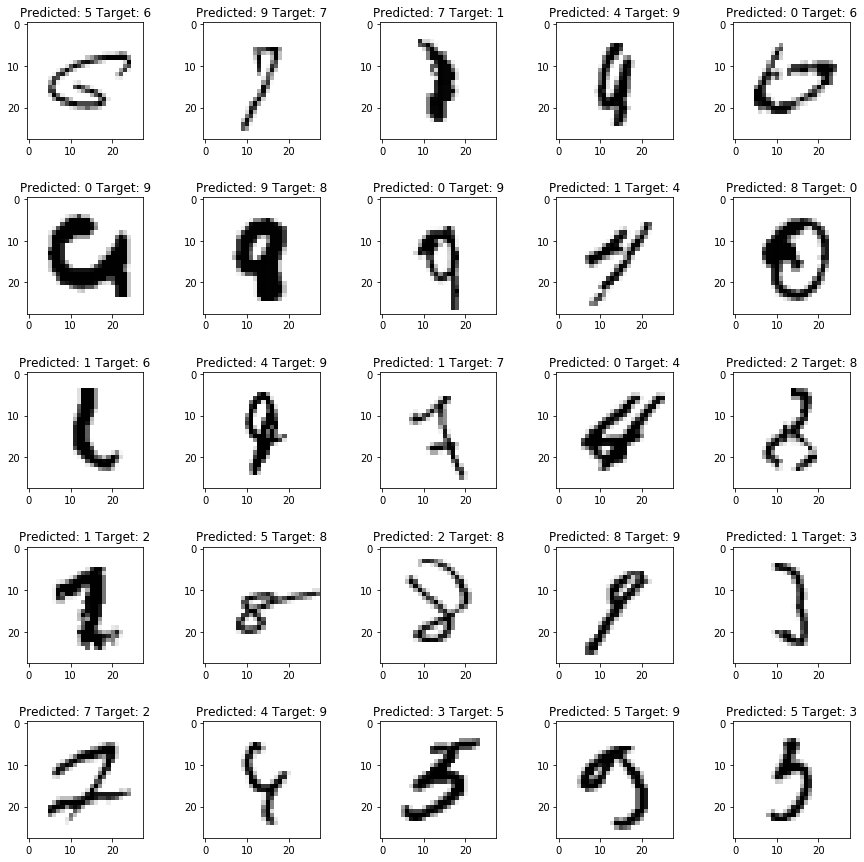

In [0]:
misclassified_images(misclassify)

In [0]:
train_acc_without_l1_l2 = train_acc.copy()
train_loss_without_l1_l2 = train_losses.copy()
test_acc_without_l1_l2 = test_acc.copy()
test_loss_without_l1_l2 = test_losses.copy()


Text(0.5, 1.0, 'Test Accuracy')

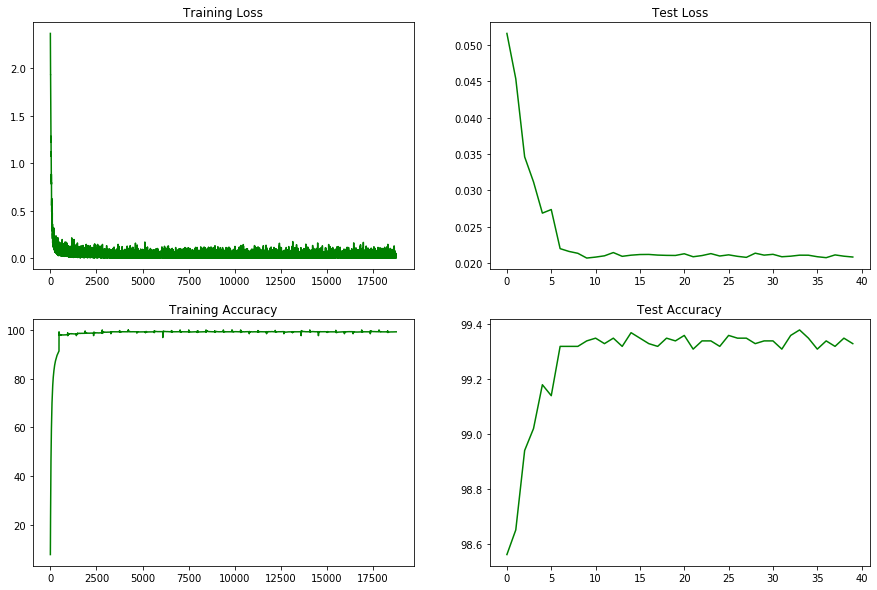

In [34]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_loss_without_l1_l2,color = 'g')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc_without_l1_l2,color = 'g')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_loss_without_l1_l2,color = 'g')
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc_without_l1_l2,color = 'g')
axs[1, 1].set_title("Test Accuracy")

In [0]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

# **With L1**

In [36]:
from torch.optim.lr_scheduler import StepLR,MultiStepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = MultiStepLR(optimizer, milestones=[6,8,12], gamma=0.1)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch,"lr = ",optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer, epoch,use_l1 = True,l1_factor=0.00005)
    scheduler.step()
    misclassify = []
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0 lr =  0.01


Loss=0.0703355222940445 Batch_id=468 Accuracy=91.84: 100%|██████████| 469/469 [00:14<00:00, 32.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0672, Accuracy: 9796/10000 (97.96%)

EPOCH: 1 lr =  0.01


Loss=0.07823927700519562 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:13<00:00, 33.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0437, Accuracy: 9864/10000 (98.64%)

EPOCH: 2 lr =  0.01


Loss=0.09236051142215729 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:13<00:00, 34.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9881/10000 (98.81%)

EPOCH: 3 lr =  0.01


Loss=0.04054092615842819 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:14<00:00, 32.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0393, Accuracy: 9890/10000 (98.90%)

EPOCH: 4 lr =  0.01


Loss=0.04512292146682739 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:14<00:00, 33.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9911/10000 (99.11%)

EPOCH: 5 lr =  0.01


Loss=0.006479338742792606 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:13<00:00, 43.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9912/10000 (99.12%)

EPOCH: 6 lr =  0.001


Loss=0.017350386828184128 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:13<00:00, 33.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9931/10000 (99.31%)

EPOCH: 7 lr =  0.001


Loss=0.03243754431605339 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:13<00:00, 44.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9929/10000 (99.29%)

EPOCH: 8 lr =  0.0001


Loss=0.01687600277364254 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:13<00:00, 34.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9930/10000 (99.30%)

EPOCH: 9 lr =  0.0001


Loss=0.08107895404100418 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 33.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9932/10000 (99.32%)

EPOCH: 10 lr =  0.0001


Loss=0.06456466764211655 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:13<00:00, 33.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9934/10000 (99.34%)

EPOCH: 11 lr =  0.0001


Loss=0.016995692625641823 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:13<00:00, 33.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9931/10000 (99.31%)

EPOCH: 12 lr =  1e-05


Loss=0.012771215289831161 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:13<00:00, 34.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9934/10000 (99.34%)

EPOCH: 13 lr =  1e-05


Loss=0.055375177413225174 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:14<00:00, 32.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9933/10000 (99.33%)

EPOCH: 14 lr =  1e-05


Loss=0.08585665374994278 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:13<00:00, 33.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9929/10000 (99.29%)

EPOCH: 15 lr =  1e-05


Loss=0.021368149667978287 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:14<00:00, 33.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9932/10000 (99.32%)

EPOCH: 16 lr =  1e-05


Loss=0.02083948813378811 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:14<00:00, 32.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9934/10000 (99.34%)

EPOCH: 17 lr =  1e-05


Loss=0.06337535381317139 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 33.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9933/10000 (99.33%)

EPOCH: 18 lr =  1e-05


Loss=0.012286131270229816 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 31.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9931/10000 (99.31%)

EPOCH: 19 lr =  1e-05


Loss=0.03289312869310379 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:14<00:00, 31.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9933/10000 (99.33%)

EPOCH: 20 lr =  1e-05


Loss=0.04963062331080437 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 31.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9932/10000 (99.32%)

EPOCH: 21 lr =  1e-05


Loss=0.02149234153330326 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:15<00:00, 31.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9933/10000 (99.33%)

EPOCH: 22 lr =  1e-05


Loss=0.011294581927359104 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:15<00:00, 36.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9929/10000 (99.29%)

EPOCH: 23 lr =  1e-05


Loss=0.005010311957448721 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:15<00:00, 39.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9927/10000 (99.27%)

EPOCH: 24 lr =  1e-05


Loss=0.0035699433647096157 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 30.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9933/10000 (99.33%)

EPOCH: 25 lr =  1e-05


Loss=0.008766302838921547 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 32.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9933/10000 (99.33%)

EPOCH: 26 lr =  1e-05


Loss=0.07399499416351318 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:15<00:00, 30.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9929/10000 (99.29%)

EPOCH: 27 lr =  1e-05


Loss=0.023483935743570328 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 29.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9934/10000 (99.34%)

EPOCH: 28 lr =  1e-05


Loss=0.02630418725311756 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 30.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9936/10000 (99.36%)

EPOCH: 29 lr =  1e-05


Loss=0.01094360463321209 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 30.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9931/10000 (99.31%)

EPOCH: 30 lr =  1e-05


Loss=0.0049857753328979015 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:15<00:00, 29.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9936/10000 (99.36%)

EPOCH: 31 lr =  1e-05


Loss=0.01113867573440075 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 30.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9931/10000 (99.31%)

EPOCH: 32 lr =  1e-05


Loss=0.035847026854753494 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 29.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9934/10000 (99.34%)

EPOCH: 33 lr =  1e-05


Loss=0.006943759974092245 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:15<00:00, 29.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9931/10000 (99.31%)

EPOCH: 34 lr =  1e-05


Loss=0.005518123507499695 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 30.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9931/10000 (99.31%)

EPOCH: 35 lr =  1e-05


Loss=0.049087412655353546 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 34.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9933/10000 (99.33%)

EPOCH: 36 lr =  1e-05


Loss=0.004283770453184843 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:15<00:00, 36.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9935/10000 (99.35%)

EPOCH: 37 lr =  1e-05


Loss=0.028044775128364563 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 29.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9931/10000 (99.31%)

EPOCH: 38 lr =  1e-05


Loss=0.004929268732666969 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 29.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9933/10000 (99.33%)

EPOCH: 39 lr =  1e-05


Loss=0.007266438566148281 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:15<00:00, 30.06it/s]



Test set: Average loss: 0.0227, Accuracy: 9933/10000 (99.33%)



In [37]:
len(misclassify)

67

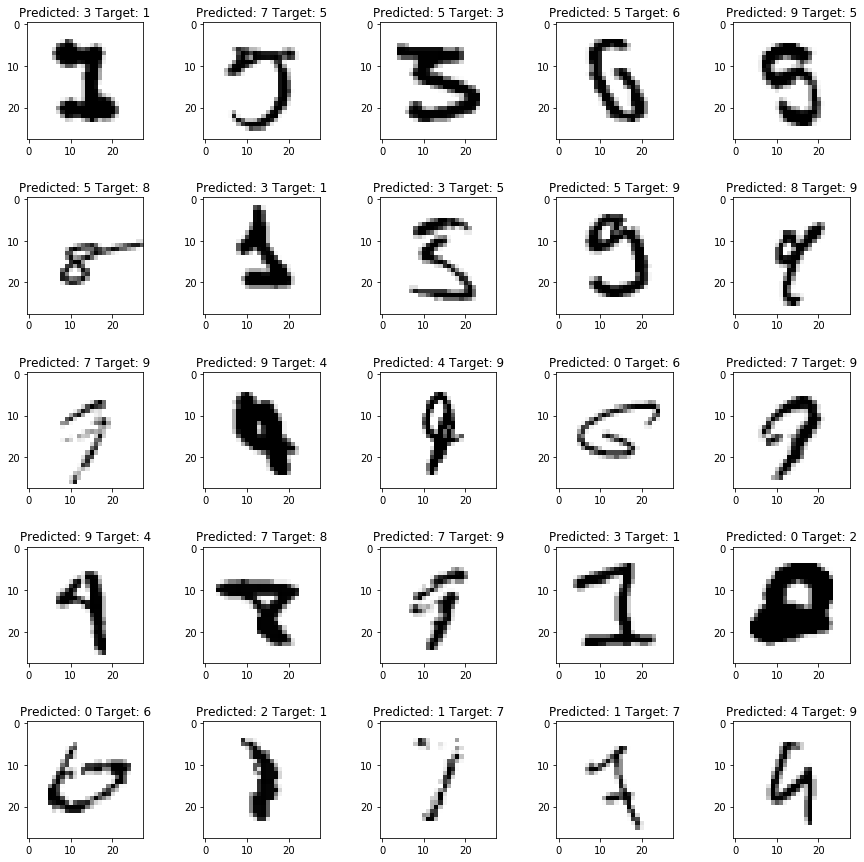

In [38]:
misclassified_images(misclassify)

In [0]:
train_acc_with_l1 = train_acc.copy()
train_loss_with_l1 = train_losses.copy()
test_acc_with_l1 = test_acc.copy()
test_loss_with_l1 = test_losses.copy()

Text(0.5, 1.0, 'Test Accuracy')

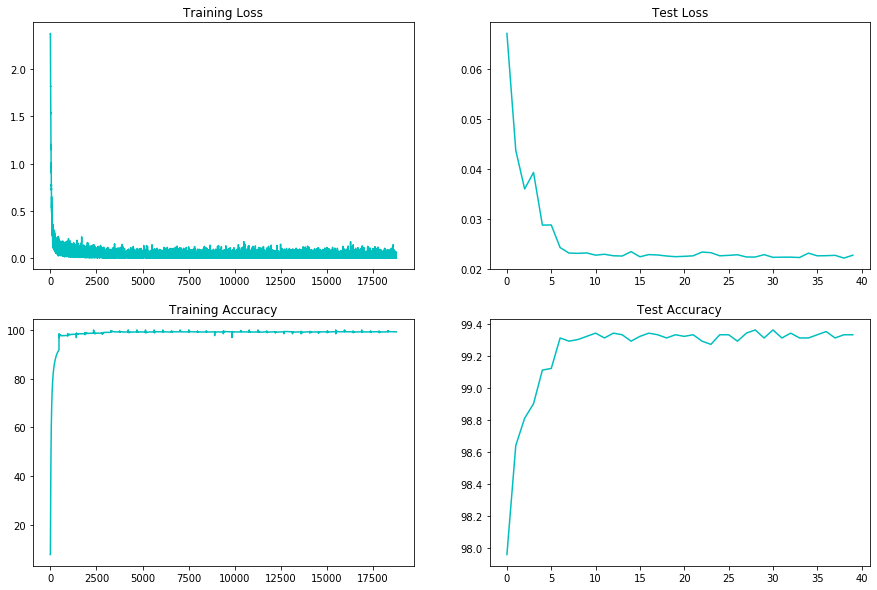

In [40]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_loss_with_l1,color='c')
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc_with_l1,color='c')

axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_loss_with_l1,color='c')

axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc_with_l1,color='c')

axs[1, 1].set_title("Test Accuracy")

In [0]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

# **With L2**

In [55]:
from torch.optim.lr_scheduler import StepLR,MultiStepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.1)
scheduler = MultiStepLR(optimizer, milestones=[6,8,12], gamma=0.1)


EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch,"lr = ",optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    misclassify = []
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0 lr =  0.01


Loss=0.5117797255516052 Batch_id=468 Accuracy=90.76: 100%|██████████| 469/469 [00:13<00:00, 35.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5902, Accuracy: 9618/10000 (96.18%)

EPOCH: 1 lr =  0.01


Loss=0.5704240202903748 Batch_id=468 Accuracy=96.66: 100%|██████████| 469/469 [00:12<00:00, 36.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4524, Accuracy: 9702/10000 (97.02%)

EPOCH: 2 lr =  0.01


Loss=0.45172667503356934 Batch_id=468 Accuracy=96.83: 100%|██████████| 469/469 [00:12<00:00, 37.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5598, Accuracy: 9688/10000 (96.88%)

EPOCH: 3 lr =  0.01


Loss=0.467934250831604 Batch_id=468 Accuracy=96.92: 100%|██████████| 469/469 [00:12<00:00, 37.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6198, Accuracy: 9269/10000 (92.69%)

EPOCH: 4 lr =  0.01


Loss=0.48930323123931885 Batch_id=468 Accuracy=96.81: 100%|██████████| 469/469 [00:12<00:00, 38.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5527, Accuracy: 9605/10000 (96.05%)

EPOCH: 5 lr =  0.01


Loss=0.5289949774742126 Batch_id=468 Accuracy=96.71: 100%|██████████| 469/469 [00:12<00:00, 37.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.7067, Accuracy: 9449/10000 (94.49%)

EPOCH: 6 lr =  0.001


Loss=0.40224650502204895 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:12<00:00, 38.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3879, Accuracy: 9860/10000 (98.60%)

EPOCH: 7 lr =  0.001


Loss=0.42492666840553284 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:12<00:00, 37.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3600, Accuracy: 9924/10000 (99.24%)

EPOCH: 8 lr =  0.0001


Loss=0.40724310278892517 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:12<00:00, 38.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3574, Accuracy: 9938/10000 (99.38%)

EPOCH: 9 lr =  0.0001


Loss=0.4197366237640381 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:12<00:00, 46.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3623, Accuracy: 9929/10000 (99.29%)

EPOCH: 10 lr =  0.0001


Loss=0.4395655691623688 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:12<00:00, 37.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3599, Accuracy: 9931/10000 (99.31%)

EPOCH: 11 lr =  0.0001


Loss=0.43492141366004944 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:12<00:00, 38.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3588, Accuracy: 9931/10000 (99.31%)

EPOCH: 12 lr =  1e-05


Loss=0.38573670387268066 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:12<00:00, 38.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3609, Accuracy: 9939/10000 (99.39%)

EPOCH: 13 lr =  1e-05


Loss=0.37334510684013367 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:12<00:00, 37.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3599, Accuracy: 9938/10000 (99.38%)

EPOCH: 14 lr =  1e-05


Loss=0.4177881181240082 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:12<00:00, 38.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3549, Accuracy: 9936/10000 (99.36%)

EPOCH: 15 lr =  1e-05


Loss=0.38330531120300293 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:12<00:00, 38.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3581, Accuracy: 9941/10000 (99.41%)

EPOCH: 16 lr =  1e-05


Loss=0.4104313552379608 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:12<00:00, 38.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3558, Accuracy: 9939/10000 (99.39%)

EPOCH: 17 lr =  1e-05


Loss=0.3895127475261688 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:11<00:00, 39.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3582, Accuracy: 9938/10000 (99.38%)

EPOCH: 18 lr =  1e-05


Loss=0.39363908767700195 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:12<00:00, 38.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3562, Accuracy: 9940/10000 (99.40%)

EPOCH: 19 lr =  1e-05


Loss=0.3985635042190552 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:11<00:00, 39.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3579, Accuracy: 9942/10000 (99.42%)

EPOCH: 20 lr =  1e-05


Loss=0.39756324887275696 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:12<00:00, 38.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3577, Accuracy: 9943/10000 (99.43%)

EPOCH: 21 lr =  1e-05


Loss=0.37927743792533875 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 40.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3578, Accuracy: 9937/10000 (99.37%)

EPOCH: 22 lr =  1e-05


Loss=0.407932847738266 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:12<00:00, 38.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3580, Accuracy: 9938/10000 (99.38%)

EPOCH: 23 lr =  1e-05


Loss=0.3784193694591522 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:11<00:00, 52.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3582, Accuracy: 9936/10000 (99.36%)

EPOCH: 24 lr =  1e-05


Loss=0.3906807005405426 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:12<00:00, 38.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3538, Accuracy: 9938/10000 (99.38%)

EPOCH: 25 lr =  1e-05


Loss=0.39425554871559143 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:11<00:00, 39.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3558, Accuracy: 9941/10000 (99.41%)

EPOCH: 26 lr =  1e-05


Loss=0.3946286737918854 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:12<00:00, 38.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3563, Accuracy: 9940/10000 (99.40%)

EPOCH: 27 lr =  1e-05


Loss=0.39093831181526184 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:11<00:00, 48.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3606, Accuracy: 9937/10000 (99.37%)

EPOCH: 28 lr =  1e-05


Loss=0.4118494689464569 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:12<00:00, 38.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3572, Accuracy: 9941/10000 (99.41%)

EPOCH: 29 lr =  1e-05


Loss=0.3859032094478607 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:12<00:00, 38.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3569, Accuracy: 9933/10000 (99.33%)

EPOCH: 30 lr =  1e-05


Loss=0.40492841601371765 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:11<00:00, 39.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3575, Accuracy: 9936/10000 (99.36%)

EPOCH: 31 lr =  1e-05


Loss=0.39781585335731506 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:11<00:00, 39.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3566, Accuracy: 9940/10000 (99.40%)

EPOCH: 32 lr =  1e-05


Loss=0.4017702043056488 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:11<00:00, 39.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3528, Accuracy: 9937/10000 (99.37%)

EPOCH: 33 lr =  1e-05


Loss=0.40885066986083984 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:11<00:00, 39.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3549, Accuracy: 9939/10000 (99.39%)

EPOCH: 34 lr =  1e-05


Loss=0.38079166412353516 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:11<00:00, 39.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3573, Accuracy: 9933/10000 (99.33%)

EPOCH: 35 lr =  1e-05


Loss=0.4043891727924347 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 39.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3562, Accuracy: 9941/10000 (99.41%)

EPOCH: 36 lr =  1e-05


Loss=0.39974483847618103 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 40.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3569, Accuracy: 9939/10000 (99.39%)

EPOCH: 37 lr =  1e-05


Loss=0.41126295924186707 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:11<00:00, 39.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3540, Accuracy: 9935/10000 (99.35%)

EPOCH: 38 lr =  1e-05


Loss=0.42602822184562683 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:11<00:00, 40.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3576, Accuracy: 9936/10000 (99.36%)

EPOCH: 39 lr =  1e-05


Loss=0.3806416988372803 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:11<00:00, 40.04it/s]



Test set: Average loss: 0.3598, Accuracy: 9940/10000 (99.40%)



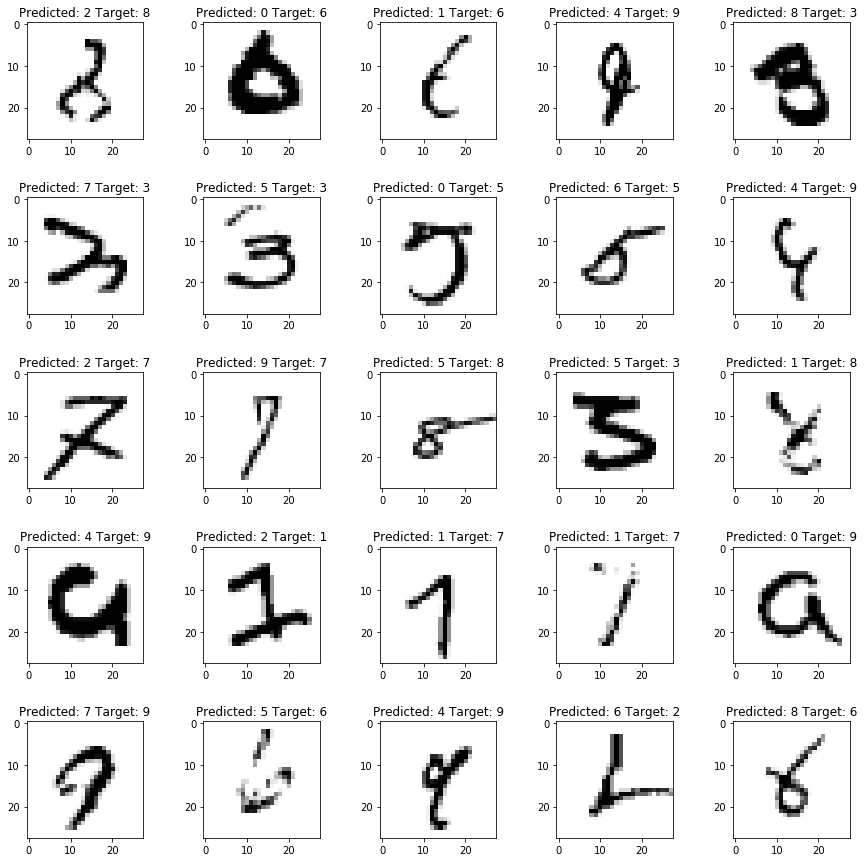

In [56]:
misclassified_images(misclassify)

In [0]:
train_acc_with_l2 = train_acc.copy()
train_loss_with_l2 = train_losses.copy()
test_acc_with_l2 = test_acc.copy()
test_loss_with_l2 = test_losses.copy()


Text(0.5, 1.0, 'Test Accuracy')

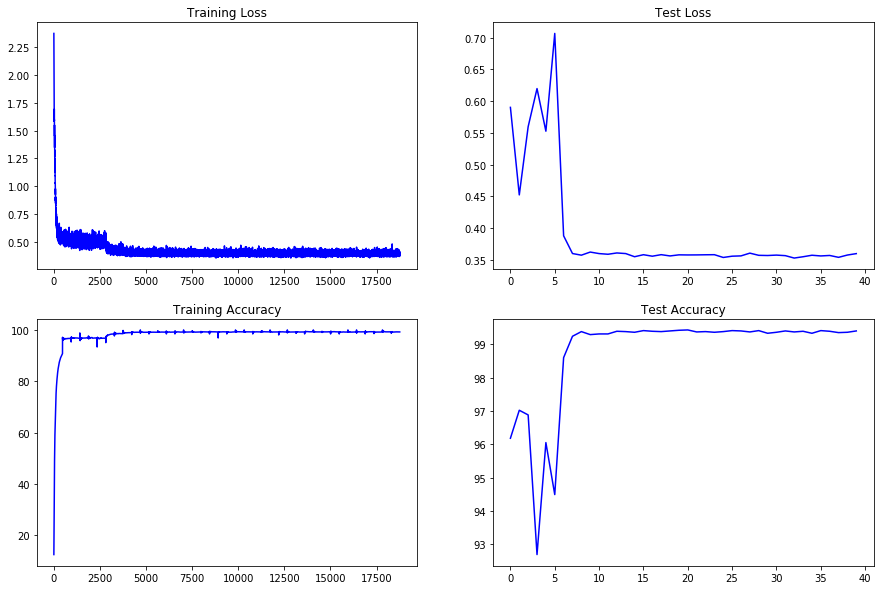

In [58]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_loss_with_l2,color = 'b')

axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc_with_l2,color = 'b')

axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_loss_with_l2,color = 'b')

axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc_with_l2,color = 'b')

axs[1, 1].set_title("Test Accuracy")

In [0]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

# **With L1 and L2**

In [60]:
from torch.optim.lr_scheduler import StepLR,MultiStepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.1)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
scheduler = MultiStepLR(optimizer, milestones=[6,8,12], gamma=0.1)


EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch,"lr = ",optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer, epoch, use_l1 = True,l1_factor=0.00005)
    scheduler.step()
    misclassify = []
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0 lr =  0.01


Loss=0.5550776720046997 Batch_id=468 Accuracy=91.73: 100%|██████████| 469/469 [00:14<00:00, 33.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5923, Accuracy: 9380/10000 (93.80%)

EPOCH: 1 lr =  0.01


Loss=0.548208475112915 Batch_id=468 Accuracy=96.71: 100%|██████████| 469/469 [00:13<00:00, 41.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6605, Accuracy: 9347/10000 (93.47%)

EPOCH: 2 lr =  0.01


Loss=0.5083745121955872 Batch_id=468 Accuracy=96.59: 100%|██████████| 469/469 [00:14<00:00, 33.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.7596, Accuracy: 8640/10000 (86.40%)

EPOCH: 3 lr =  0.01


Loss=0.4665876030921936 Batch_id=468 Accuracy=96.65: 100%|██████████| 469/469 [00:13<00:00, 33.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5291, Accuracy: 9610/10000 (96.10%)

EPOCH: 4 lr =  0.01


Loss=0.5138744711875916 Batch_id=468 Accuracy=96.78: 100%|██████████| 469/469 [00:13<00:00, 42.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.7432, Accuracy: 9131/10000 (91.31%)

EPOCH: 5 lr =  0.01


Loss=0.4625926613807678 Batch_id=468 Accuracy=96.67: 100%|██████████| 469/469 [00:14<00:00, 33.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5768, Accuracy: 9442/10000 (94.42%)

EPOCH: 6 lr =  0.001


Loss=0.4711173474788666 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:14<00:00, 32.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3687, Accuracy: 9908/10000 (99.08%)

EPOCH: 7 lr =  0.001


Loss=0.4280681312084198 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:14<00:00, 38.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3878, Accuracy: 9872/10000 (98.72%)

EPOCH: 8 lr =  0.0001


Loss=0.38569095730781555 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 33.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3637, Accuracy: 9933/10000 (99.33%)

EPOCH: 9 lr =  0.0001


Loss=0.378660649061203 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:13<00:00, 34.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3614, Accuracy: 9930/10000 (99.30%)

EPOCH: 10 lr =  0.0001


Loss=0.40807077288627625 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:13<00:00, 33.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3553, Accuracy: 9931/10000 (99.31%)

EPOCH: 11 lr =  0.0001


Loss=0.42795440554618835 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:13<00:00, 39.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3586, Accuracy: 9926/10000 (99.26%)

EPOCH: 12 lr =  1e-05


Loss=0.38076141476631165 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 33.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3571, Accuracy: 9933/10000 (99.33%)

EPOCH: 13 lr =  1e-05


Loss=0.40772274136543274 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:13<00:00, 33.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3527, Accuracy: 9934/10000 (99.34%)

EPOCH: 14 lr =  1e-05


Loss=0.40143275260925293 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:13<00:00, 33.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3558, Accuracy: 9933/10000 (99.33%)

EPOCH: 15 lr =  1e-05


Loss=0.4015796482563019 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:13<00:00, 33.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3534, Accuracy: 9934/10000 (99.34%)

EPOCH: 16 lr =  1e-05


Loss=0.36974865198135376 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:13<00:00, 40.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3569, Accuracy: 9932/10000 (99.32%)

EPOCH: 17 lr =  1e-05


Loss=0.3989831507205963 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 33.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3545, Accuracy: 9933/10000 (99.33%)

EPOCH: 18 lr =  1e-05


Loss=0.3964778780937195 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:13<00:00, 43.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3553, Accuracy: 9932/10000 (99.32%)

EPOCH: 19 lr =  1e-05


Loss=0.38975730538368225 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 32.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3562, Accuracy: 9935/10000 (99.35%)

EPOCH: 20 lr =  1e-05


Loss=0.3844236135482788 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:13<00:00, 34.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3516, Accuracy: 9937/10000 (99.37%)

EPOCH: 21 lr =  1e-05


Loss=0.39875465631484985 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 32.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3537, Accuracy: 9935/10000 (99.35%)

EPOCH: 22 lr =  1e-05


Loss=0.3619566261768341 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 32.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3565, Accuracy: 9934/10000 (99.34%)

EPOCH: 23 lr =  1e-05


Loss=0.3846856355667114 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 32.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3554, Accuracy: 9933/10000 (99.33%)

EPOCH: 24 lr =  1e-05


Loss=0.3806845247745514 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:15<00:00, 30.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3548, Accuracy: 9936/10000 (99.36%)

EPOCH: 25 lr =  1e-05


Loss=0.3826737701892853 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 39.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3542, Accuracy: 9934/10000 (99.34%)

EPOCH: 26 lr =  1e-05


Loss=0.3954836130142212 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:14<00:00, 41.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3547, Accuracy: 9933/10000 (99.33%)

EPOCH: 27 lr =  1e-05


Loss=0.39000141620635986 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:14<00:00, 42.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3538, Accuracy: 9934/10000 (99.34%)

EPOCH: 28 lr =  1e-05


Loss=0.3869529664516449 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:15<00:00, 30.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3537, Accuracy: 9935/10000 (99.35%)

EPOCH: 29 lr =  1e-05


Loss=0.4255622923374176 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:14<00:00, 31.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3509, Accuracy: 9935/10000 (99.35%)

EPOCH: 30 lr =  1e-05


Loss=0.4105347692966461 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:14<00:00, 31.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3540, Accuracy: 9935/10000 (99.35%)

EPOCH: 31 lr =  1e-05


Loss=0.3681336045265198 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 31.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3570, Accuracy: 9935/10000 (99.35%)

EPOCH: 32 lr =  1e-05


Loss=0.4301148056983948 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:14<00:00, 31.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3503, Accuracy: 9936/10000 (99.36%)

EPOCH: 33 lr =  1e-05


Loss=0.4067249000072479 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 38.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3495, Accuracy: 9937/10000 (99.37%)

EPOCH: 34 lr =  1e-05


Loss=0.42205488681793213 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:14<00:00, 33.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3523, Accuracy: 9933/10000 (99.33%)

EPOCH: 35 lr =  1e-05


Loss=0.40111470222473145 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 31.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3534, Accuracy: 9937/10000 (99.37%)

EPOCH: 36 lr =  1e-05


Loss=0.40708082914352417 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:14<00:00, 33.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3539, Accuracy: 9932/10000 (99.32%)

EPOCH: 37 lr =  1e-05


Loss=0.4118090867996216 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:14<00:00, 32.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3544, Accuracy: 9931/10000 (99.31%)

EPOCH: 38 lr =  1e-05


Loss=0.4018806517124176 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:13<00:00, 34.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3523, Accuracy: 9935/10000 (99.35%)

EPOCH: 39 lr =  1e-05


Loss=0.37504634261131287 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:13<00:00, 34.49it/s]



Test set: Average loss: 0.3531, Accuracy: 9932/10000 (99.32%)



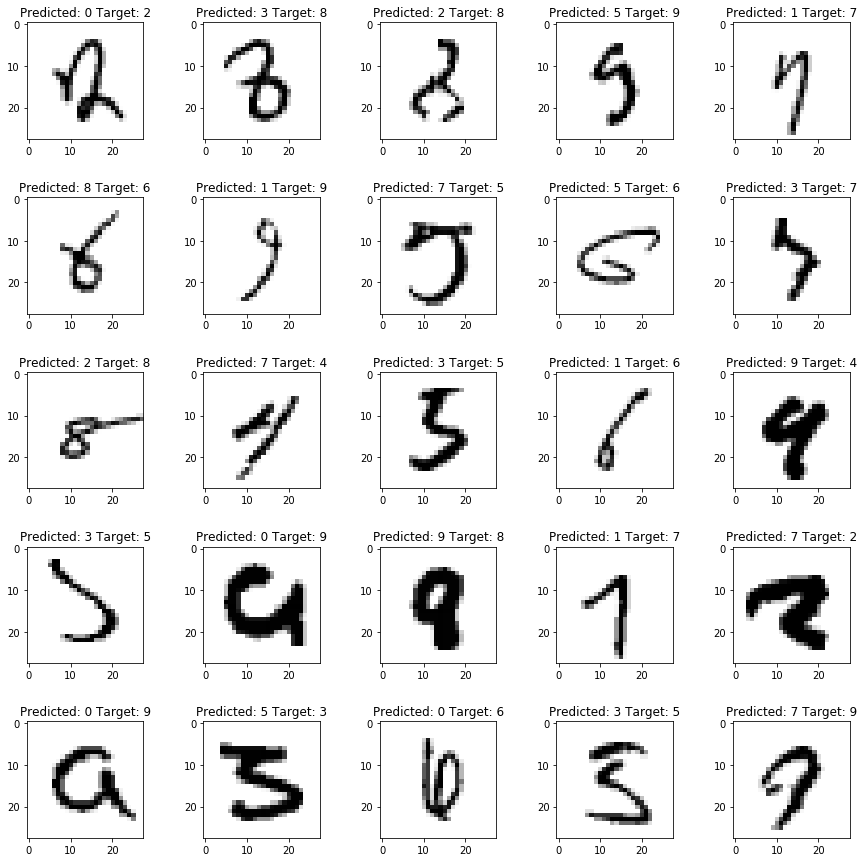

In [61]:
misclassified_images(misclassify)

In [0]:
train_acc_with_l1_l2 = train_acc.copy()
train_loss_with_l1_l2 = train_losses.copy()
test_acc_with_l1_l2 = test_acc.copy()
test_loss_with_l1_l2 = test_losses.copy()

Text(0.5, 1.0, 'Test Accuracy')

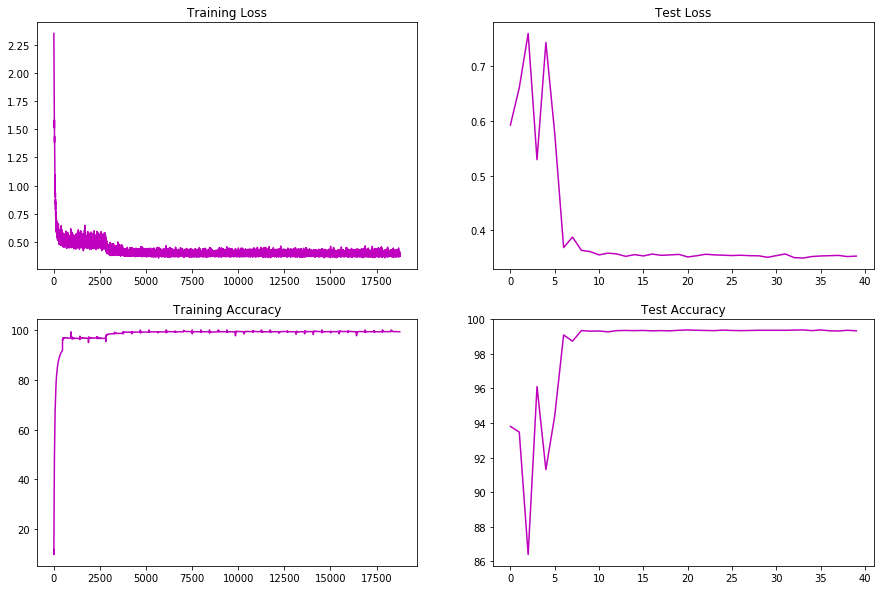

In [63]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_loss_with_l1_l2,color = 'm')

axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc_with_l1_l2,color = 'm')

axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_loss_with_l1_l2,color = 'm')

axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc_with_l1_l2,color = 'm')

axs[1, 1].set_title("Test Accuracy")

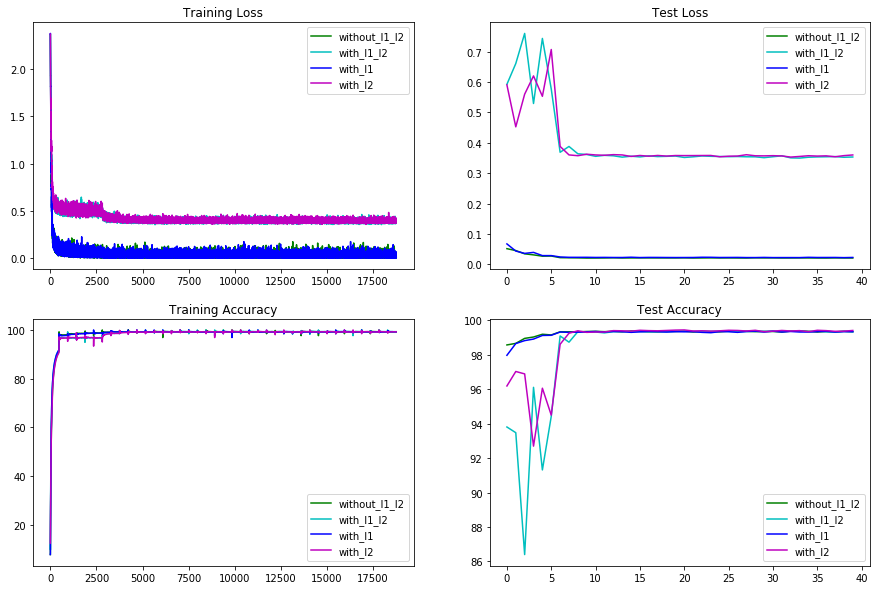

In [64]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_loss_without_l1_l2,color = 'g',label="without_l1_l2")
axs[0, 0].plot(train_loss_with_l1_l2,color = 'c',label="with_l1_l2")
axs[0, 0].plot(train_loss_with_l1,color = 'b',label="with_l1")
axs[0, 0].plot(train_loss_with_l2,color = 'm',label="with_l2")
axs[0, 0].set_title("Training Loss")
axs[0, 0].legend()
axs[1, 0].plot(train_acc_without_l1_l2,color = 'g',label="without_l1_l2")
axs[1, 0].plot(train_acc_with_l1_l2,color = 'c',label="with_l1_l2")
axs[1, 0].plot(train_acc_with_l1,color = 'b',label="with_l1")
axs[1, 0].plot(train_acc_with_l2,color = 'm',label="with_l2")
axs[1, 0].set_title("Training Accuracy")
axs[1, 0].legend()
axs[0, 1].plot(test_loss_without_l1_l2,color = 'g',label="without_l1_l2")
axs[0, 1].plot(test_loss_with_l1_l2,color = 'c',label="with_l1_l2")
axs[0, 1].plot(test_loss_with_l1,color = 'b',label="with_l1")
axs[0, 1].plot(test_loss_with_l2,color = 'm',label="with_l2")
axs[0, 1].set_title("Test Loss")
axs[0, 1].legend()
axs[1, 1].plot(test_acc_without_l1_l2,color = 'g',label="without_l1_l2")
axs[1, 1].plot(test_acc_with_l1_l2,color = 'c',label="with_l1_l2")
axs[1, 1].plot(test_acc_with_l1,color = 'b',label="with_l1")
axs[1, 1].plot(test_acc_with_l2,color = 'm',label="with_l2")
axs[1, 1].set_title("Test Accuracy")
axs[1, 1].legend()

Text(0.5, 0.98, 'l1 = 0.00005, l2 = 0.1')

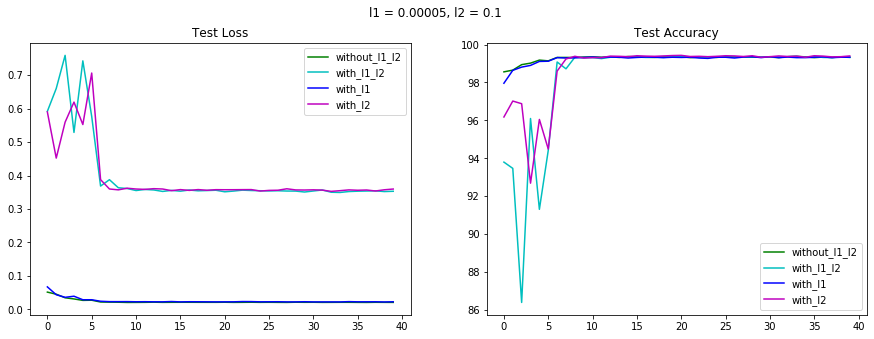

In [65]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(test_loss_without_l1_l2,color = 'g',label="without_l1_l2")
axs[0].plot(test_loss_with_l1_l2,color = 'c',label="with_l1_l2")
axs[0].plot(test_loss_with_l1,color = 'b',label="with_l1")
axs[0].plot(test_loss_with_l2,color = 'm',label="with_l2")
axs[0].set_title("Test Loss")
axs[0].legend()
axs[1].plot(test_acc_without_l1_l2,color = 'g',label="without_l1_l2")
axs[1].plot(test_acc_with_l1_l2,color = 'c',label="with_l1_l2")
axs[1].plot(test_acc_with_l1,color = 'b',label="with_l1")
axs[1].plot(test_acc_with_l2,color = 'm',label="with_l2")
axs[1].set_title("Test Accuracy")
axs[1].legend()
fig.suptitle("l1 = 0.00005, l2 = 0.1")